In [1]:
import fsspec
import zarr
import xarray as xr
import random
import matplotlib.pyplot as plt
import numpy as np

# Demo access with xarray

This section aims at showing how much time is needed to randomly access data from a remote data cube in a non optimal way.

We open a connection to a remote data cube (UC3 sub cube for time series analysis) and access its five variables: avg_rh ignition_points time burned_areas lst_day x evi y

In [62]:
m = fsspec.get_mapper("https://storage.de.cloud.ovh.net/v1/AUTH_84d6da8e37fe4bb5aea18902da8c1170/uc3/UC3SubCube_ts.zarr")
g = xr.open_zarr(m)
g

,Array,Chunk
Bytes,20.92 GiB,781.25 kiB
Shape,"(4560, 983, 1253)","(500, 20, 20)"
Count,31501 Tasks,31500 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,20.92 GiB,781.25 kiB
Shape,"(4560, 983, 1253)","(500, 20, 20)"
Count,31501 Tasks,31500 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


We then randomly sample 20 locations in the cube over a fixed time range

In [63]:
randlat = list(map(lambda x: random.randrange(g.dims['y']),range(20)))
randlon = list(map(lambda x: random.randrange(g.dims['x']),range(20)))
print(randlat)
print(randlon)

[670, 394, 64, 929, 593, 401, 194, 861, 699, 3, 134, 480, 314, 331, 892, 364, 737, 452, 284, 164]
[1002, 30, 960, 279, 896, 466, 1003, 1141, 102, 662, 116, 1029, 959, 960, 336, 958, 827, 1187, 54, 1134]


In [64]:
lonind = xr.DataArray(randlon,dims = "points")
latind = xr.DataArray(randlat,dims="points")
selection = g.isel(y=latind,x=lonind).loc[dict(time=slice("2009-01-01", "2016-12-31"))]
selection
#selection = g.isel(x=randlon, y=randlat)]

<xarray.Dataset>
Dimensions:          (time: 2858, points: 20)
Coordinates:
  * time             (time) datetime64[ns] 2009-03-06T10:00:00 ... 2016-12-31...
    x                (points) float64 26.86 18.95 26.52 ... 28.37 19.14 27.94
    y                (points) float64 36.84 39.09 41.78 ... 38.62 39.99 40.96
Dimensions without coordinates: points
Data variables:
    avg_rh           (time, points) float32 dask.array<chunksize=(500, 20), meta=np.ndarray>
    burned_areas     (time, points) float32 dask.array<chunksize=(500, 20), meta=np.ndarray>
    evi              (time, points) float32 dask.array<chunksize=(500, 20), meta=np.ndarray>
    ignition_points  (time, points) float32 dask.array<chunksize=(500, 20), meta=np.ndarray>
    lst_day          (time, points) float32 dask.array<chunksize=(500, 20), meta=np.ndarray>

In [65]:
selection = selection.compute()

In [66]:
type(selection)

xarray.core.dataset.Dataset

In [68]:
selection.dims

Frozen({'time': 2858, 'points': 20})

We use this selection to plot evi.

Text(0.5, 1.0, 'data accessed with xarray')

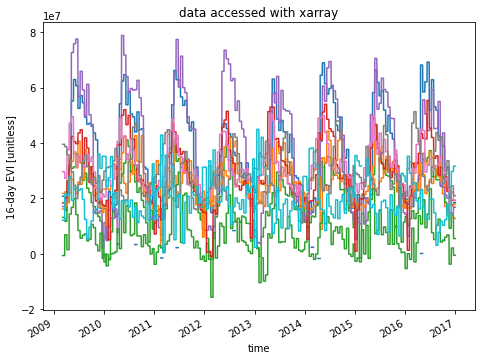

In [6]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
for i in range(selection.dims["points"]):
    y = selection.evi.isel(points=i)
    y.plot.line(ax=ax)

ax.set_title("data accessed with xarray")

# BatchShuffler

[BatchShuffleServer](https://github.com/meggart/BatchShuffleServer) gives an example of how to launch a server for the sampler from a Docker containor.

First we need to build the docker:

```bash
sudo docker build -t batchshuffler .
```
Once the docker is built, the server can be launched by running the docker with the following parameters. 

```bash
path_to_cube="https://storage.de.cloud.ovh.net/v1/AUTH_84d6da8e37fe4bb5aea18902da8c1170/uc3/UC3SubCube_ts.zarr"
vars_to_include="burned_areas,avg_rh,ignition_points,lst_day,evi"
start_year=2009
end_year=2016
repeats_per_collection=20
batchsize=100
nchunks=10
ip="0.0.0.0"
port=9052
fillvalue="1.0e32"


docker run -p 9052:9052 batchshuffler $path_to_cube -v $vars_to_include -s $start_year -e $end_year -r $repeats_per_collection -b $batchsize -n $nchunks --ip $ip -p $port -f $fillvalue
```

In this case we sample a subset of the UC3 cube for five variables (burned_areas, avg_rh, ignition_points, lst_day, evi) for years 2009 to 2016. 
Each batch consits of 100 collections of 20 randomly sampled locations.
10 chunks are held in memory contemporarily.

The server runs at the IP address and port specified within the container. The above instructions can be saved in a file, e.g. [launch_server.sh](https://github.com/meggart/BatchShuffleServer/launch_server.sh).

```
./launch_server.sh
```

On Linux, the ip address of the server can be retrieved with:

```bash
sudo ip addr show docker0
```

On MacOS, you get the container id or name with `docker ps` to obtain the port number. localhost is generally running at IP address 127.0.0.1. You can check that by running `ifconfig`.

Once the server is launched, it can be called following the demo below.
You can check that the server is running with a request to http://localhost:9052/.zmetadata. It should return a .JSON with the metadata. Adapt the IP address and port as needed.

# Demo with batch shuffler


In [3]:
# m = fsspec.get_mapper("http://macadamia.bgc-jena.mpg.de:9052")
# change the ip address as necessary
# localhost:[exposed port]
m = fsspec.get_mapper("https://batchshuffler.deepcube.gael-systems.com")#("http://127.0.0.1:9052")
g = zarr.open_consolidated(m)

In [4]:
batches = g["batches"]

In [5]:
batches.shape

(100, 5, 2858)

In [6]:
type(batches)

zarr.core.Array

Each call to `batches`draws a new batch of 100 samples. Every 20 draws, a new collection of batches is generated.

In [8]:
# collect data (compare time with cell #5)
data = batches[:,:,:]

Text(0.5, 0, 'time since 2009 [days]')

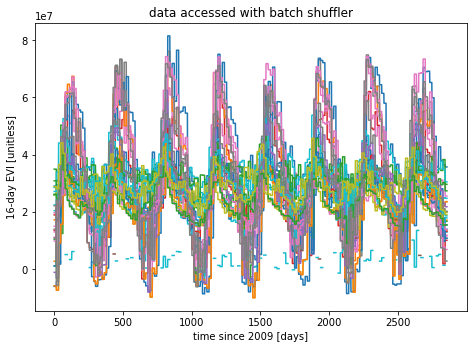

In [9]:
fill_value = 1e32
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
evi = batches[:,4,:]
for i in range(100):
    y = evi[i,:]
    ax.plot(np.ma.masked_where(y == fill_value, y))

ax.set_title("data accessed with batch shuffler")
ax.set_ylabel("16-day EVI [unitless]")
ax.set_xlabel("time since 2009 [days]")